# Katrin Experiment

## Introduction

The Neutrino is a fundamental particle, embedded in the Standard Model. They were first postulated by Wolfgang Pauli to explain the missing energy in the energy spectrum of the electron in radioactive $\beta$-decay.  
The occurrence of Neutrino oscillations proves that Neutrinos have mass, as opposed to originally believed. However, these experiments are sensitive to the difference of the squared massed of two mass states and therefore don't show the absolute mass scale of the Neutrino.  
The Karlsruhe Tritium Neutrino (KATRIN) experiment attempts to measure the mass of neutrinos with precision.  
This notebook attempts to replicate the results of the KATRIN experiment by first using a simplified model of the Tritium $\beta$-decay spectrum that is unique to KATRIN with Monte Carlo Data and then using basics of Data Analysis to set an upper and lower bound to the neutrino mass to evaluate the sensitivity of the experiment.

**NOTE**:  
  The KATRIN experiment uses Tritium in its molecular form, therefor the daughter molecule in the $\beta$-decay can be in a rotational-vibrational or electronically excited state which lowers the effective energy of the electron and neutrino and shifts the endpoint. Tritium molecules in the source are also in thermal motion and can experience the Doppler effect and broaden the differential spectrum. Lastly, we have to account for potential energy losses in inelastic scattering process in the source.
  I will neglect these effects to save computational time, but we will see that it still returns values close to what the real Katrin experiment measures.

In [2]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.stats as stats

In [3]:
%matplotlib inline

# 1. The Model
## 1.1 Differential Spectrum

In [4]:
# Global Constants
C = 1.433488e-13            # Prefactor
m_e = 0.51099895e6          # Electron mass (in eV)
alpha = 7.2973525693e-3     # Fine structure constant

In [5]:
def fermi_function(beta: float) -> float:
    """Approximation of the relativistic fermi function.    
    Parameters
    ----------
    beta: Relativisstic beta factor."""
    
    eta = 2*alpha/beta
    
    return (2*np.pi*eta)/(1-np.exp(-2*np.pi*eta)) * (1.002037 - 0.001427*beta)

In [6]:
def differential_spectrum(E: float, mnu2: float, E_0: float) -> float:
    """Differential spectrum.
    Parameters
    ----------
    E: Electron energy.
    mnu2: Neutrino mass squared.
    E0: Endpoint.
    Returns
    ----------
    Differential rate.
    """
    # Calculate approximations
    E_tot = E + m_e
    p = np.sqrt(E_tot**2 - m_e**2)
    beta = E_tot/p
    F = fermi_function(beta)
    # Calculate mnu
    m_nu = np.sqrt(mnu2*np.heaviside(mnu2, 0))
    # Calculation differential rate
    return np.nan_to_num(C * F * p * (E+m_e) * (E_0 - E) * np.sqrt((E_0 - E)**2 
            - mnu2) * np.heaviside(E_0 - E - m_nu,0))

/tmp/ipykernel_10278/910648528.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(C * F * p * (E+m_e) * (E_0 - E) * np.sqrt((E_0 - E)**2
/tmp/ipykernel_10278/3479936209.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


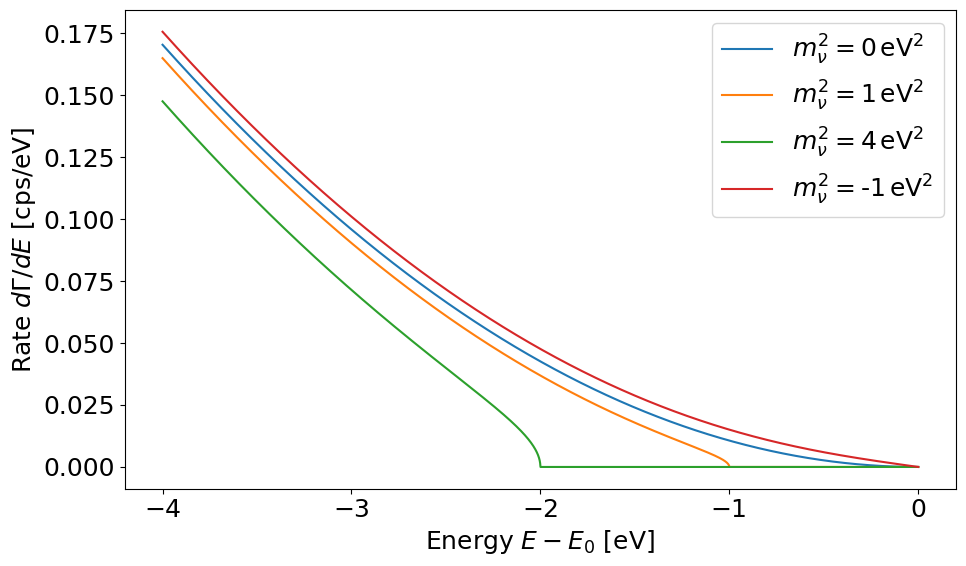

In [7]:
# positive neutrino masses
import cmath
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

# energy values where the differential spectrum is evaluated
x = np.linspace(18569.7, 18573.7, 10000)

x0 = 18573.7 #To transform E to E-E_0

for mnu2 in [0,1,4,-1]: # neutrino masses
    y = differential_spectrum(E=x, mnu2=mnu2, E_0=18573.7)
    ax.plot(x-x0, y, '-', label=r"$m_{\nu}^2=$"+f"{mnu2:.0f}"+r"$\,\mathrm{eV}^2$")


ax.legend()
plt.locator_params(axis='x', nbins=5)
ax.set_xlabel(r"Energy $E-E_0$ [eV]")
ax.set_ylabel(r"Rate $d\Gamma/dE$ [cps/eV]")
#save fig
plt.tight_layout()
plt.savefig("fig/differentialSpectrum.png", dpi=300)


### 1.2 Transmission function ###

In [8]:
def transmission(qU, E, *, Bana=6.3e-4, Bmax=4.23, Bsource=2.52) -> float:
    """Transmission function of the spectrometer.
    
    Parameters
    ----------
    qU: Retarding energy.
    E: Electron energy.
    Bana: Magnetic field in the analyzing plane.
    Bmax: Maximal magnetic field.
    Bsource: Magnetic field in the source.
    
    Returns
    ----------
    Transmission probability.
    """
    # Compute relativistic factor
    f = (((E-qU)/m_e)+2)/((E/m_e)+2)
    # Compute slope part of transmission
    T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /
                       (1 - np.sqrt(1 - Bsource/Bmax) ) )
    # Put everything together with heaviside functions
    return ( np.heaviside(E - qU, 1) * T 
            * np.heaviside(qU * (f*Bmax) / (f*Bmax - Bana) - E, 1) 
            + np.heaviside(E - qU * (f*Bmax) / (f*Bmax - Bana), 0) )

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /


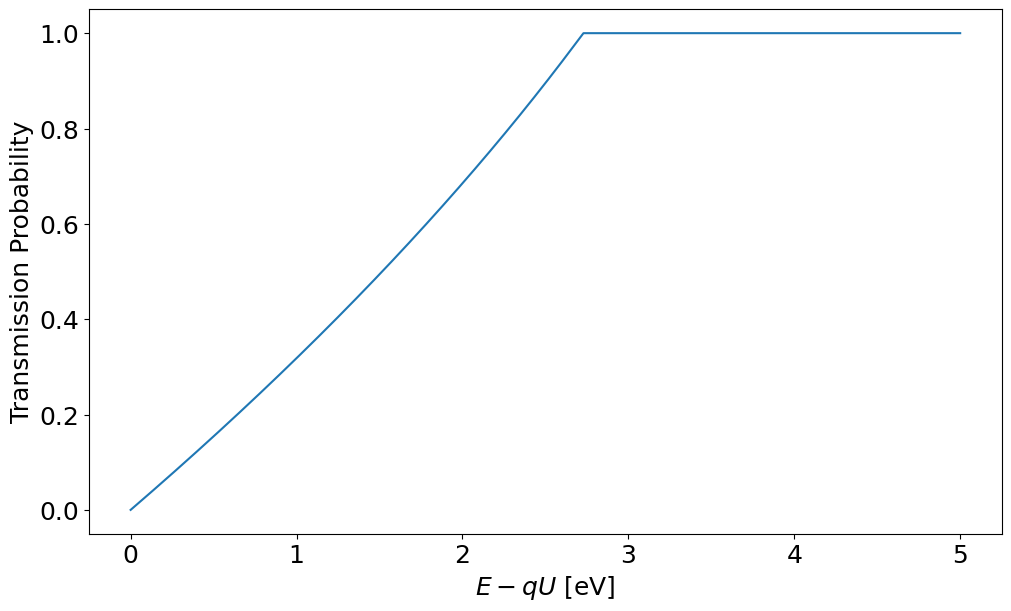

In [9]:
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

# the qU should be close to the tritium endpoint but not higher
qU = 18e3

# the energy ranging from values smaller than qU to larger than qU
x = np.linspace(18e3, 18e3+5, 10000)
y = transmission(qU=qU, E=x, Bana=6.3e-4, Bmax=4.23, Bsource=2.52)

ax.plot(x-qU, y, '-')
plt.locator_params(axis='x', nbins=7)
ax.set_xlabel(r"$E-qU$ [eV]")
ax.set_ylabel(r"Transmission Probability")
plt.show()

### Transmission function for different Bana 

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /
/tmp/ipykernel_10278/1253556815.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


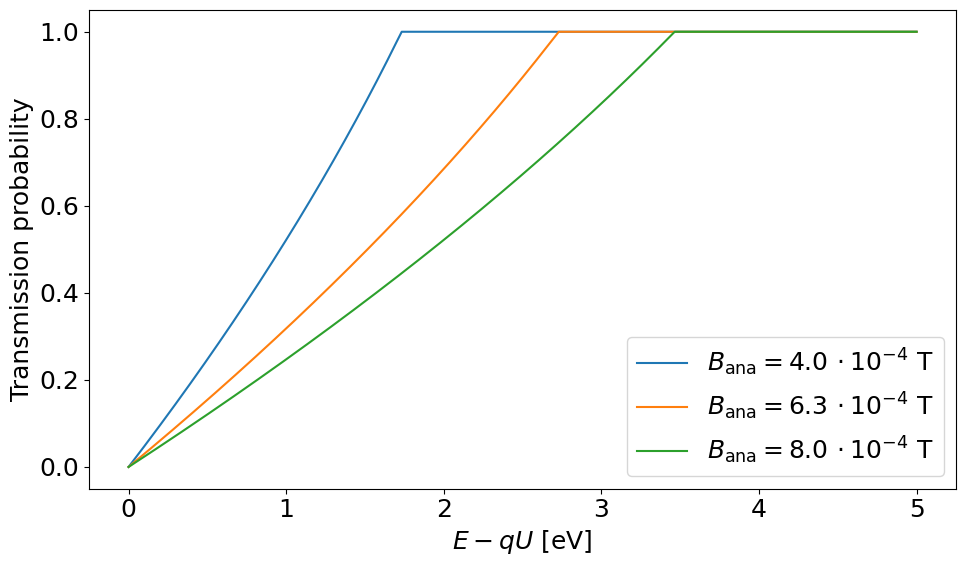

In [10]:
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

qU = 18e3
x = np.linspace(18e3, 18e3+5, 10000)

for Bana in [4e-4,6.3e-4,8e-4]:
    y = transmission(qU=qU, E=x, Bana=Bana, Bmax=4.23, Bsource=2.52)
    ax.plot(x-qU, y, '-', label=r"$B_{\mathrm{ana}}=%s \, \cdot 10^{-4}$ T"%f"{Bana*1E4:.1f}");

ax.legend()
plt.locator_params(axis='x', nbins=7)
ax.set_xlabel("$E-qU$ [eV]")
ax.set_ylabel("Transmission probability")

#save fig
plt.tight_layout()
plt.savefig("fig/transmission_varBana.png", dpi=300)

### Transmission function for different Bmax

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /
/tmp/ipykernel_10278/1444149071.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


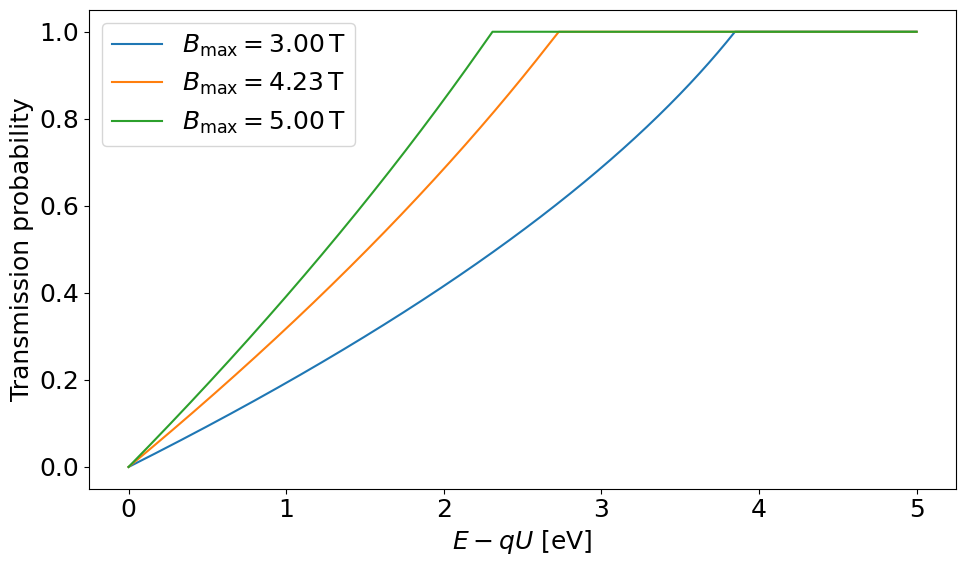

In [11]:
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6));

qU = 18e3
x = np.linspace(18e3, 18e3+5, 10000)

for Bmax in [3,4.23,5]:
    y = transmission(qU=qU, E=x, Bana=6.3e-4, Bmax=Bmax, Bsource=2.52)
    ax.plot(x-qU, y, '-', label=r"$B_{\mathrm{max}}=%s \,$T"%f"{Bmax:.2f}");

ax.legend()
plt.locator_params(axis='x', nbins=7)
ax.set_xlabel("$E-qU$ [eV]")
ax.set_ylabel("Transmission probability")

#save fig
plt.tight_layout()
plt.savefig("fig/transmission_varBmax.png", dpi=300)

### 1.3 Dummy model ###

In [12]:
def integrated_spectrum(qU: float, mnu2: float, E_0: float) -> float:
    """Integrated spectrum.
    
    Parameters
    ----------
    qU: Retarding energy.
    mnu2: Neutrino mass squared.
    E0: Endpoint.
    
    Returns
    ----------
    Integrated rate.
    """
    # Define integrand
    def integrand(x: float) -> float:
        return ( differential_spectrum(E=x, mnu2=mnu2, E_0=E_0) 
                * transmission(qU=qU, E=x) )
    # Calculate the integral
    return integrate.quad(integrand, qU, E_0)[0]

In [13]:
def dummy_model(qU: float, mnu2: float, E_0: float, B: float, N: float) -> float:
    """Dummy model.
    
    Parameters
    ----------
    qU: Retarding energy.
    mnu2: Neutrino mass squared.
    E0: Endpoint.
    B: Background.
    N: Normalization.
    
    Returns
    ----------
    Model rate at qU.
    """
    return N*integrated_spectrum(qU=qU, mnu2=mnu2, E_0=E_0)+B

/tmp/ipykernel_10278/910648528.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(C * F * p * (E+m_e) * (E_0 - E) * np.sqrt((E_0 - E)**2
/tmp/ipykernel_10278/1865318411.py:19: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(integrand, qU, E_0)[0]
/tmp/ipykernel_10278/2307865607.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


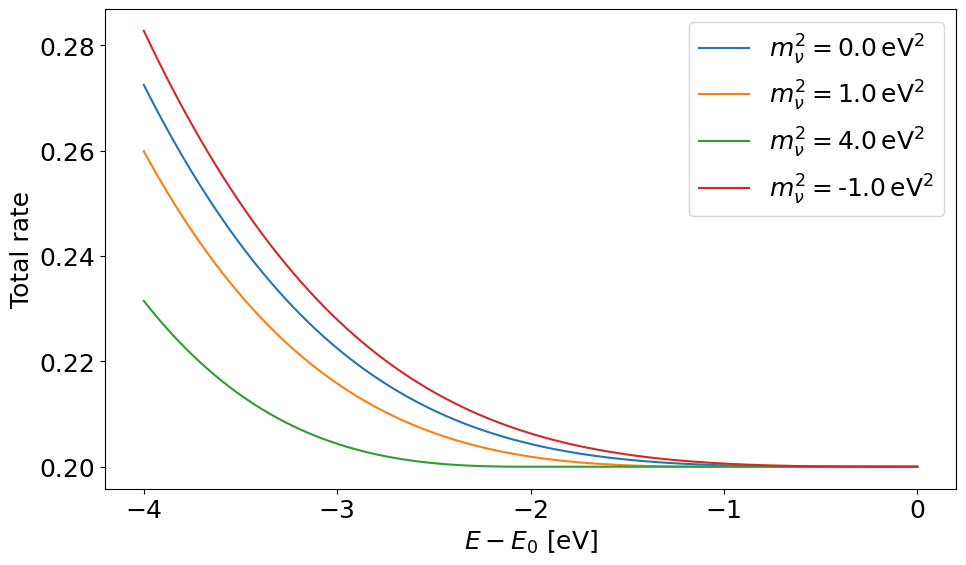

In [14]:
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6));

x = np.linspace(18569.7,18573.7,100) # energy range

for mnu2 in [0,1,4,-1]:
    y = np.array([dummy_model(qU=_x, mnu2=mnu2, E_0=18573.7, B=.2, N=1) for _x in x])
    ax.plot(x-18573.7, y, '-', label=r"$m_{\nu}^2=$"+f"{mnu2:.1f}"+r"$\,\mathrm{eV}^2$");

ax.legend()

plt.locator_params(axis='x', nbins=6)
ax.set_xlabel(r"$E-E_0$ [eV]")
ax.set_ylabel("Total rate")

#save fig
plt.tight_layout()
plt.savefig("fig/integralSpectrum.png", dpi=300)

### Define parameters for Rchanged

In [15]:
mnu2 = [0.5, 1] # different neutrino mass values
E_0 = [18573.6, 18573.8] # different endpoint values
N = [0.9, 1.1] # different normalization values
B = [0.19,0.21] # different background values

# Compute reference model
x = np.linspace(18535,18581,100) # energy range
# reference model
yref = np.array([dummy_model(qU=_x, mnu2=0, E_0=18573.7, B=0.2, N=1) for _x in x])

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /


### Influence of each parameter in Response function at endpoint region

### Mass influence

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /
/tmp/ipykernel_10278/910648528.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(C * F * p * (E+m_e) * (E_0 - E) * np.sqrt((E_0 - E)**2
/tmp/ipykernel_10278/2724113762.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


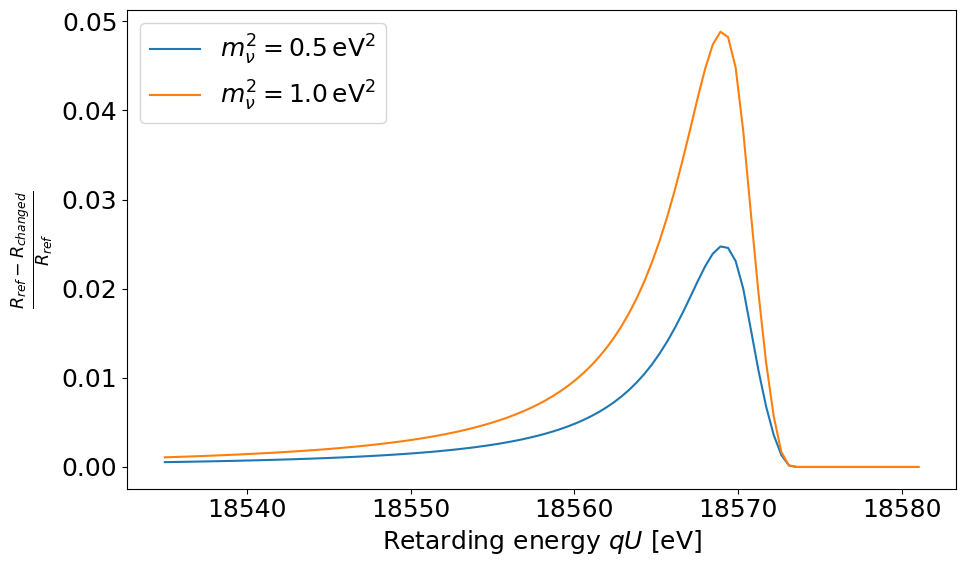

In [16]:
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

for _mnu2 in mnu2:
    ychanged = np.array([dummy_model(qU=_x, mnu2=_mnu2, E_0=18573.7, B=0.2, N=1) for _x in x])
    # insert relation of reference and changed spectrum
    ax.plot(x, (yref-ychanged)/yref, '-', label=r"$m_{\nu}^2=$"+f"{_mnu2:.1f}"+r"$\,$eV$^2$")
    
ax.legend()
plt.locator_params(axis='x', nbins=6)
ax.set_xlabel(r"Retarding energy $qU$ [eV]")
ax.set_ylabel(r"$\frac{R_{ref}-R_{changed}}{R_{ref}}$")

plt.tight_layout()
plt.savefig("fig/ComparisonFunc_mnu2.png", dpi=300)


### Endpoint energy influence

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /
/tmp/ipykernel_10278/3389550235.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


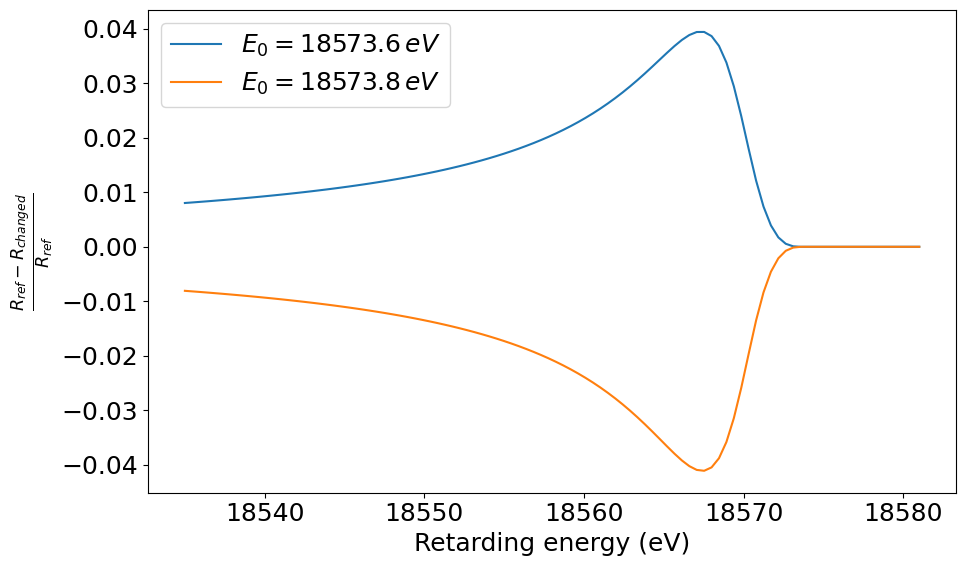

In [17]:
plt.rcParams.update({'font.size':18});
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

for _E_0 in E_0:
    ychanged = np.array([dummy_model(qU=_x, mnu2=0, E_0=_E_0, B=0.2, N=1) for _x in x])
    ax.plot(x, (yref-ychanged)/yref, '-', label=r"$E_0=$"+f"{_E_0:.1f}"+r"$\,$$eV$")
    
ax.legend();
plt.locator_params(axis='x', nbins=6)
ax.set_xlabel("Retarding energy (eV)")
ax.set_ylabel(r"$\frac{R_{ref}-R_{changed}}{R_{ref}}$")

plt.tight_layout()
plt.savefig("fig/ComparisonFunc_E0.png", dpi=300)

### Background count influence

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /
/tmp/ipykernel_10278/1312576724.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


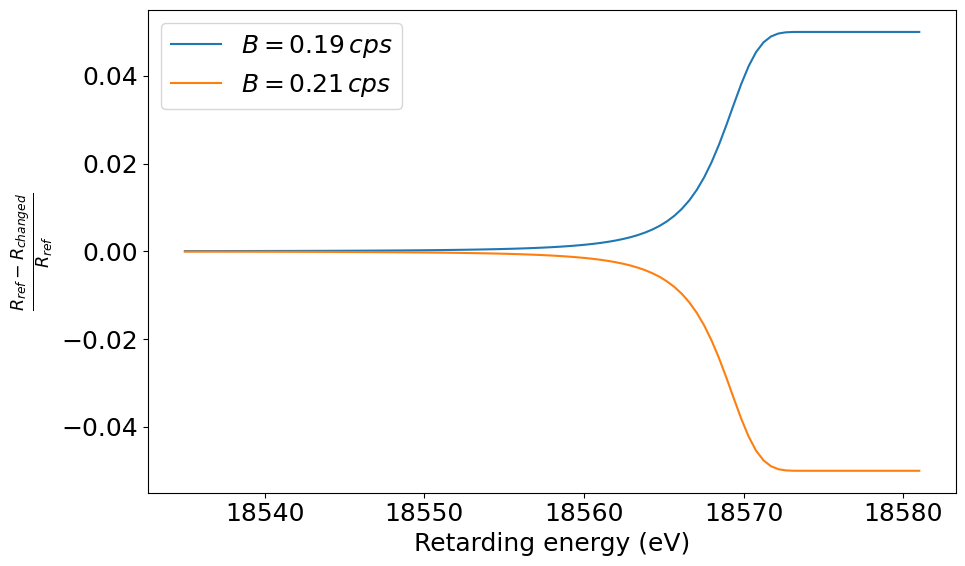

In [18]:
plt.rcParams.update({'font.size':18});
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

for _B in B:
    ychanged = np.array([dummy_model(qU=_x, mnu2=0, E_0=18573.7, B=_B, N=1) for _x in x])
    ax.plot(x, (yref-ychanged)/yref, '-', label=r"$B=$"+f"{_B:.2f}"+r"$\,$$cps$")

ax.legend();
plt.locator_params(axis='x', nbins=6)
ax.set_xlabel("Retarding energy (eV)")
ax.set_ylabel(r"$\frac{R_{ref}-R_{changed}}{R_{ref}}$")

plt.tight_layout()
plt.savefig("fig/ComparisonFunc_B.png", dpi=300)

### Normalization factor influence

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /
/tmp/ipykernel_10278/1315439.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


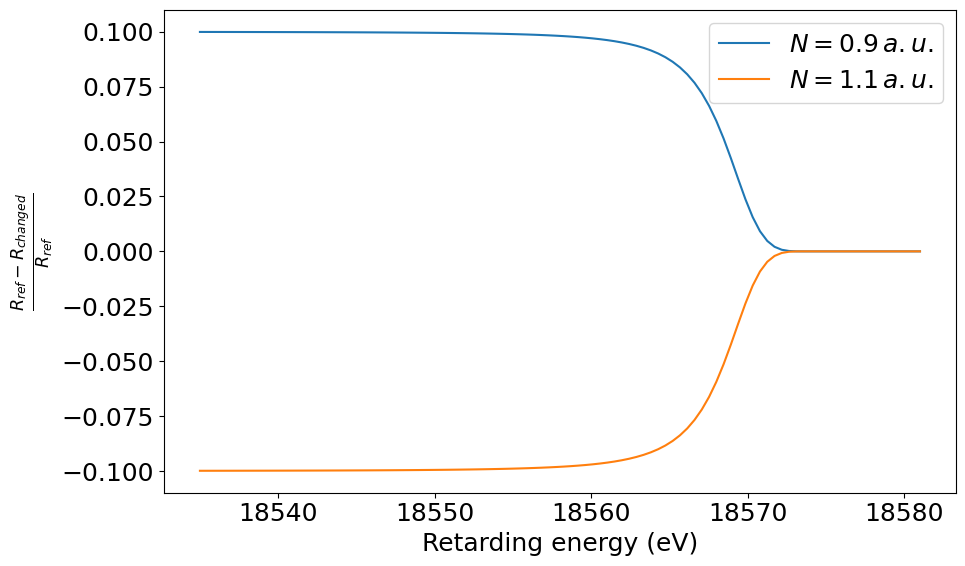

In [19]:
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

for _N in N:
    ychanged = np.array([dummy_model(qU=_x, mnu2=0, E_0=18573.7, B=0.2, N=_N) for _x in x])
    ax.plot(x, (yref-ychanged)/yref, '-', label=r"$N=$"+f"{_N:.1f}"+r"$\,$$a.u.$")

ax.legend()
plt.locator_params(axis='x', nbins=6)
ax.set_xlabel("Retarding energy (eV)")
ax.set_ylabel(r"$\frac{R_{ref}-R_{changed}}{R_{ref}}$")

plt.tight_layout()
plt.savefig("fig/ComparisonFunc_N.png", dpi=300)

In [20]:
def root_search(x):
    return 1*integrated_spectrum(qU=x, mnu2=0, E_0=18573.7)+0.2 - 0.4

print(f"The signal-to-background ratio is 1 at qU={optimize.root_scalar(root_search, bracket=(18535, 18581)).root:.2f}")

/tmp/ipykernel_10278/970346160.py:19: RuntimeWarning: invalid value encountered in sqrt
  T = np.nan_to_num( (1 - np.sqrt(1 - f * Bsource/Bana * (E - qU)/E )) /


The signal-to-background ratio is 1 at qU=18568.53


### 2 Basics of Data Analysis

In [21]:
def simplified_model(E: float, mnu2: float, E_0: float, B: float, N: float) -> float:
    """Simplified (differential) model.
    
    Parameters
    ----------
    E: Energy.
    mnu2: Neutrino mass squared.
    E0: Endpoint.
    B: Background.
    N: Normalization.
    
    Returns
    ----------
    Model rate at qU.
    """
    return N*differential_spectrum(E=E, mnu2=mnu2, E_0=E_0)+B

### 2.1 Monte Carlo Data

In [22]:
# MCD
Elin = np.linspace(18535,18581,24) # energy points
tlin = np.ones(24)/24 # relative fraction of total measurement time
ttot = 750*24*3600 # give total time in seconds

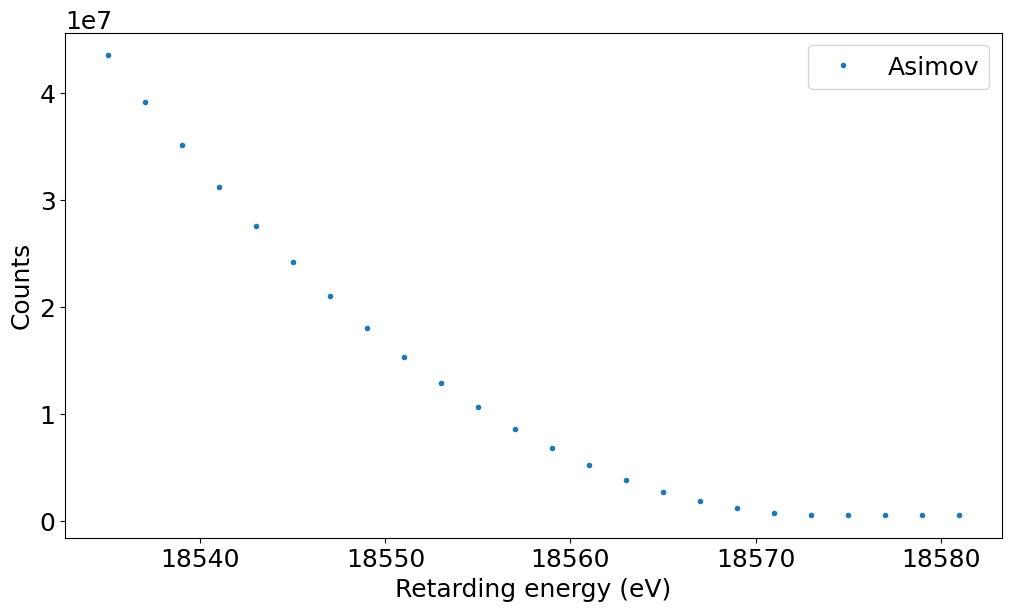

In [23]:
# Calculate Asimov spectrum (WILL SERVE AS EXPECTED DATA)
rate_asimov = simplified_model(E=Elin, mnu2=0, E_0=18573.7, N=1, B=0.2)
counts_asimov = rate_asimov*tlin*ttot

# Plot Asimov spectrum in terms of rate
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
ax.plot(Elin, counts_asimov, '.', label="Asimov")

plt.locator_params(axis='x', nbins=6)
ax.set_xlabel("Retarding energy (eV)")
ax.set_ylabel("Counts")
ax.legend()

###  $10^4$ Poisson distributed spectra will serve as measurement data 

/tmp/ipykernel_10278/4136512314.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


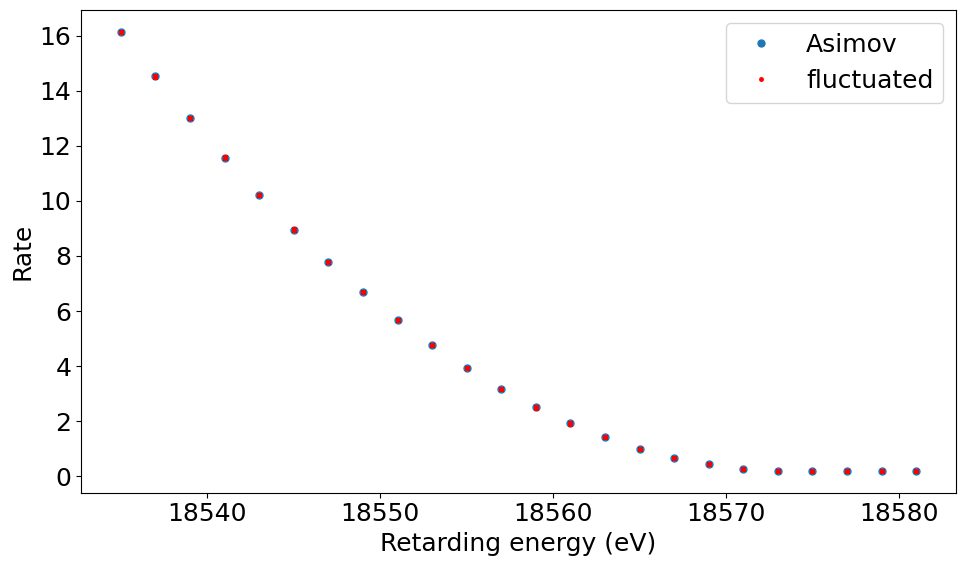

In [24]:
# Generate fluctuated spectra
fluctuated_spectra = []
for c in counts_asimov:
    fluctuated_spectra.append(np.random.poisson(lam=c, size=int(1e4))) 
fluctuated_spectra = np.array(fluctuated_spectra).T 

# Plot one fluctuated spectrum together with the Asimov one (in terms of rate)
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
ax.plot(Elin, rate_asimov, '.', label="Asimov",markersize=10)
for _spectra in fluctuated_spectra:
    ax.plot(Elin, _spectra/(tlin*ttot), '.', color='r',markersize=5)
ax.plot(Elin, fluctuated_spectra[0]/(tlin*ttot), '.', color='r', label="fluctuated",markersize=5)

plt.locator_params(axis='x', nbins=6)
ax.set_xlabel("Retarding energy (eV)")
ax.set_ylabel("Rate")
ax.legend()

plt.tight_layout()
plt.savefig("fig/AsimovAndFluctuatedRate.png", dpi=300)

### Distribution of the rate of the Fluctuated spectra against Asimov rate

/tmp/ipykernel_10278/3657167552.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


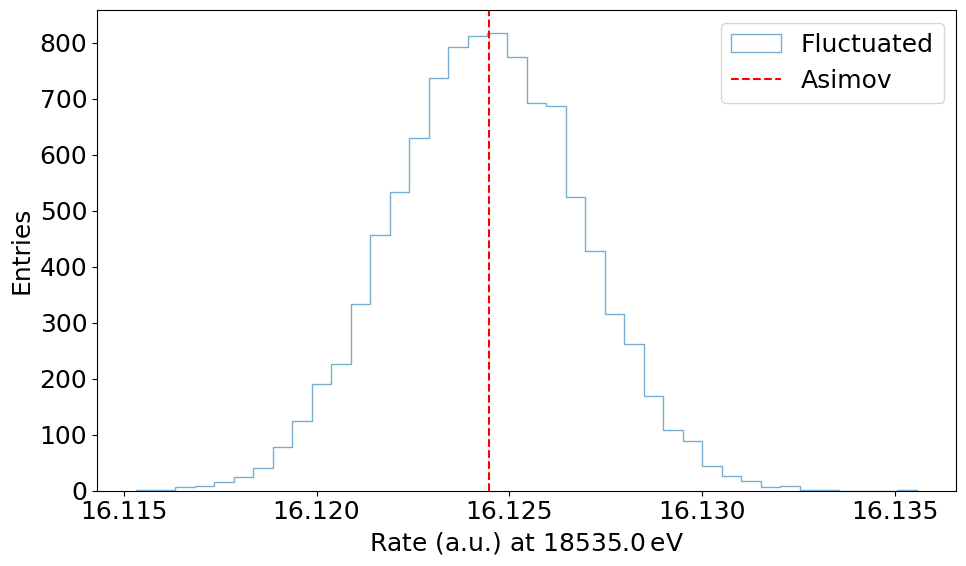

In [25]:
qUIndex = 0 # Get the point in the spectrum by index
asimov = counts_asimov[qUIndex]/(tlin*ttot)[qUIndex]
fluctuated = fluctuated_spectra[:, qUIndex]/(tlin*ttot)[qUIndex] 

plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6));
ax.hist(fluctuated, bins=40, alpha=0.6, label=f"Fluctuated", histtype="step")
ax.axvline(asimov, label="Asimov", color='r', linestyle="--")

plt.locator_params(axis='x', nbins=5);
ax.set_xlabel(f"Rate (a.u.) at {Elin[qUIndex]:.1f}" +r"$\,$eV");
ax.ticklabel_format(useOffset=False)
ax.set_ylabel("Entries")
ax.legend()

plt.tight_layout()
plt.savefig("fig/distributionAsimovAndFluctuated_RATE.png")

### Relative deviation from expected value

/tmp/ipykernel_10278/1755453358.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_10278/1755453358.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


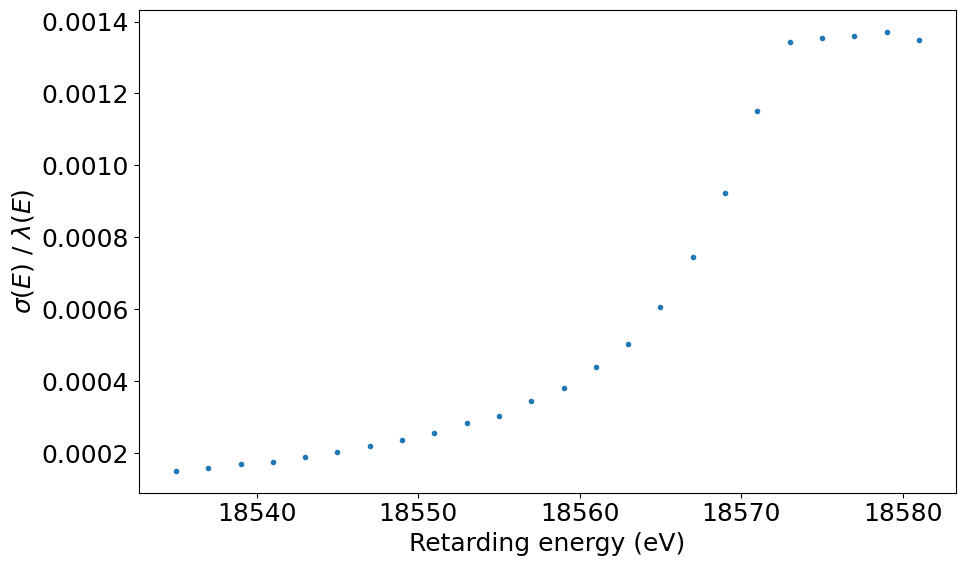

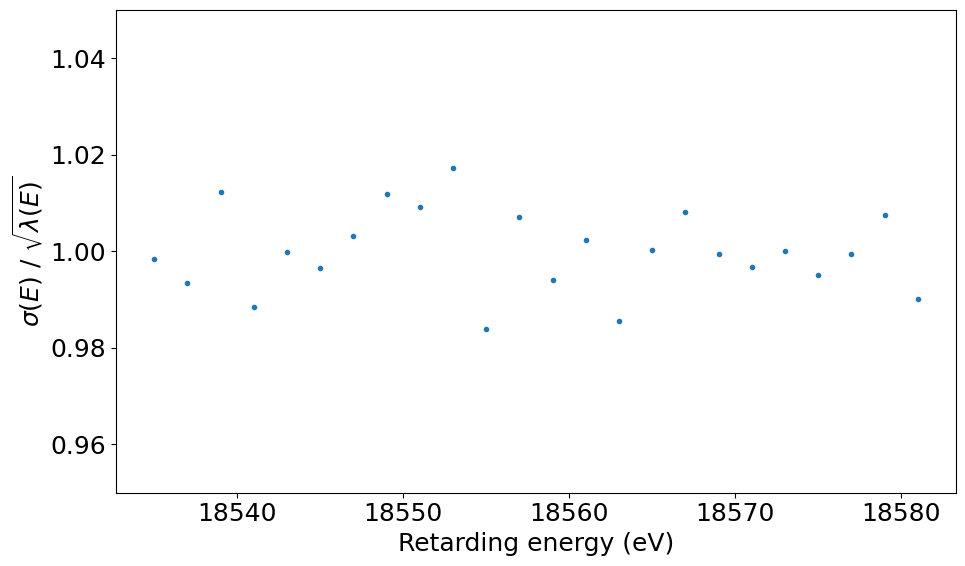

In [26]:
# Calculate standard deviation at each E
sigma = np.std(fluctuated_spectra, axis=0) # standard deviation of the fluctuated spectra

# Plot the standard deviation vs lambda
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6));
ax.plot(Elin, sigma/counts_asimov, '.')

plt.locator_params(axis='x', nbins=6)
ax.set_xlabel("Retarding energy (eV)")
ax.set_ylabel(r"$\sigma(E)$ / $\lambda(E)$")
plt.tight_layout()
plt.savefig("fig/stdVsTotalcounts.png", dpi=300)

# Plot the standard deviation vs the expectation
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
ax.plot(Elin, sigma/np.sqrt(counts_asimov), '.')


plt.locator_params(axis='x', nbins=6)
ax.set_xlabel("Retarding energy (eV)")
ax.set_ylabel(r"$\sigma(E)$ / $\sqrt{\lambda(E)}$")
plt.ylim([0.95, 1.05])

plt.tight_layout()
plt.savefig("fig/RelativeDeviation.png", dpi=300)

### 2.2 Parameter Inference ###

In [27]:
def chisquared(func, xdata: np.array, ydata: np.array, pmodel: np.array, sigma: np.array) -> float:
    """Returns the chi squared for given function and values.

    Parameters
    ----------
    func: Model function.
    xdata: Data of the x-axis.
    ydata: Data of the y-axis. Must have the same shape as xdata.
    pmodel: Model parameters
    sigma: Uncertainty of ydata. Must have the same shape as xdata of has to be a float.

    Returns
    ----------
    Chi Squared for model and values.
    """
    return np.sum(((func(xdata, *pmodel)-ydata)/sigma)**2)

In [28]:
# Define chi2 as a function of parameters for fixed Asimov data
def chi2(params) -> float:
    """Return the chi2 as a function of params"""
    mnu2, E0, B, N = params
    xdata = Elin
    ydata = rate_asimov # rate
    sigma = np.sqrt(counts_asimov)/(tlin*ttot) # sigma is here the uncertainty on the rate
    return chisquared(func=simplified_model, xdata=xdata, ydata=ydata, pmodel=params, sigma=sigma)

In [29]:
# Fit Asimov data using chi2 minimization
# Initial value of the minimizer for the parameters as array [val1, val2, val3, val4]
x0 = [0.,18573.7,0.2,1.3] # change one parameter value slightly with regard to the reference values to ensure correct minimization
# Minimize 
result_asimov = optimize.minimize(chi2, x0=x0, method="Nelder-Mead", tol=1e-8)
print("### Fit on Asimov data ###")
print("Best fit at: ", result_asimov.x)
print(f"Chi2 = {result_asimov.fun}")

### Fit on Asimov data ###
Best fit at:  [2.05330649e-03 1.85737001e+04 2.00002526e-01 9.99996313e-01]
Chi2 = 0.0014920476096204767


/tmp/ipykernel_10278/910648528.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(C * F * p * (E+m_e) * (E_0 - E) * np.sqrt((E_0 - E)**2


In [30]:
# Do the same on fluctuated data
Parameters = []
for i, dataset in enumerate(fluctuated_spectra): # insert the fluctuated spectra
    # Print progress
    print(f"Progress: {(i+1)/len(fluctuated_spectra)*1E2:.1f}%", end="\r", flush=True)
    # Adapt definition of chi2 for different data
    def _chi2(params) -> float:
        """Return the chi2 as a function of params"""
        xdata = Elin
        ydata = dataset/(ttot*tlin)
        sigma = np.sqrt(dataset)/(ttot*tlin)
        return chisquared(func=simplified_model, xdata=xdata, ydata=ydata, pmodel=params, sigma=sigma)
    # Initial value for parameters
    x0 = [0.,1.85737e+04,.2,1.]  # array [val1, val2, val3, val4]
    # Minimize 
    result = optimize.minimize(_chi2, x0=x0, method="Nelder-Mead", tol=1e-8)
    if result.success:
        Parameters.append([*result.x, result.fun])
    else:
        print(f"Minimization did not converge")
Parameters = np.array(Parameters)

### Distribution of the fluctuated spectra parameters

/tmp/ipykernel_5473/87571399.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


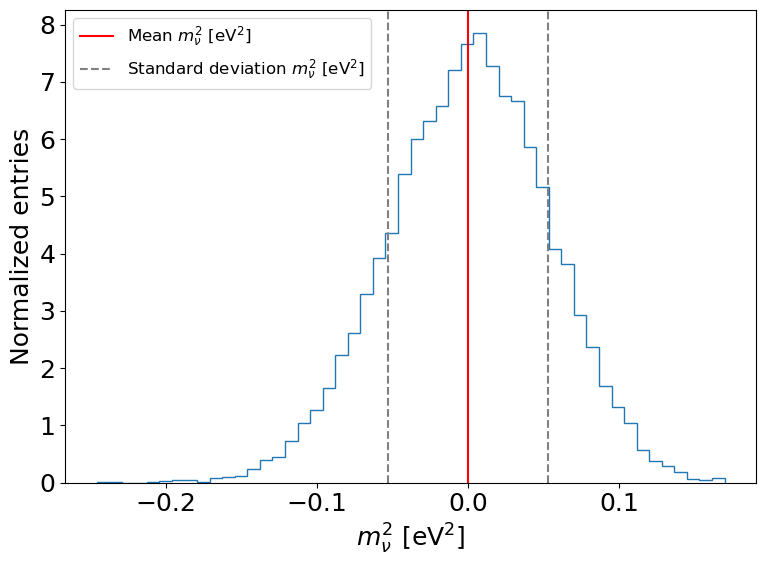

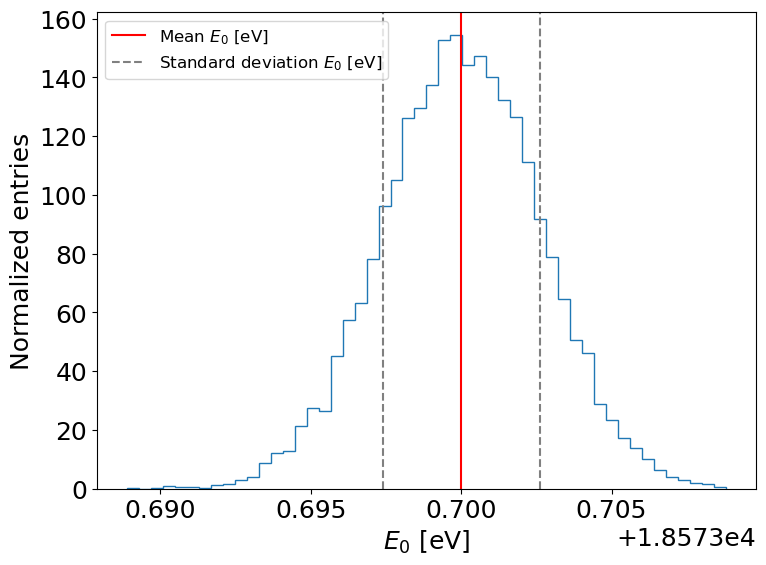

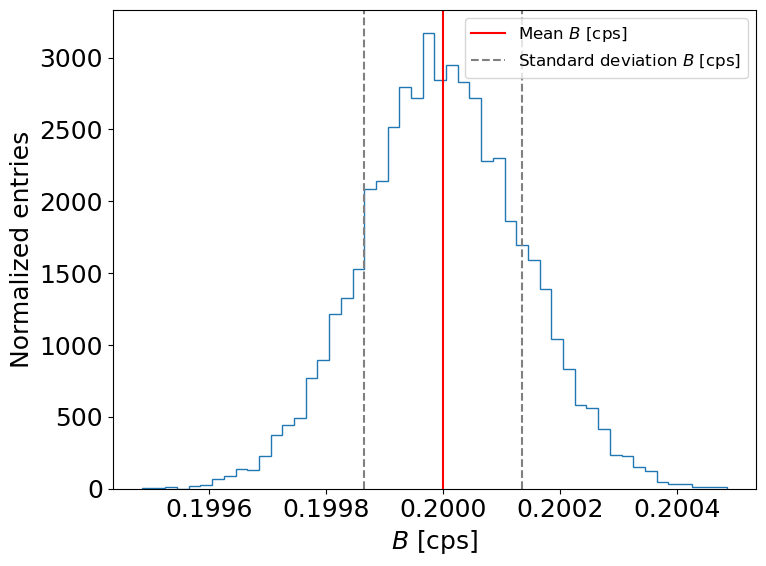

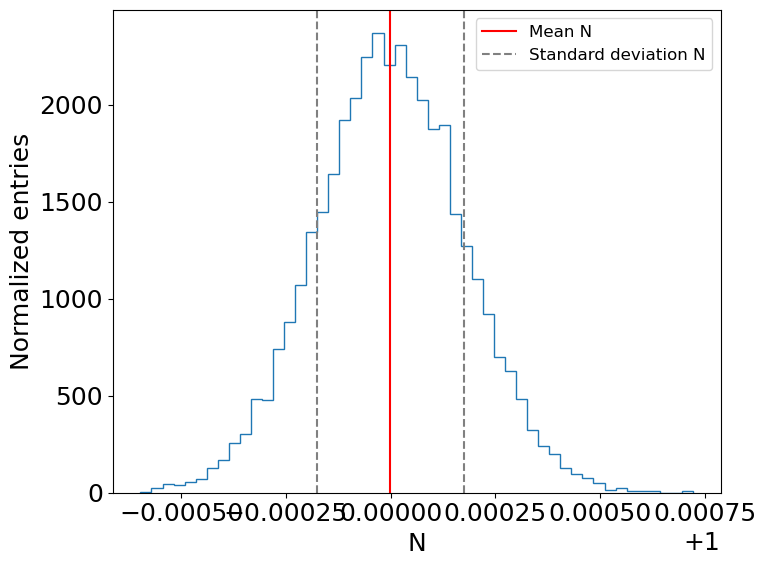

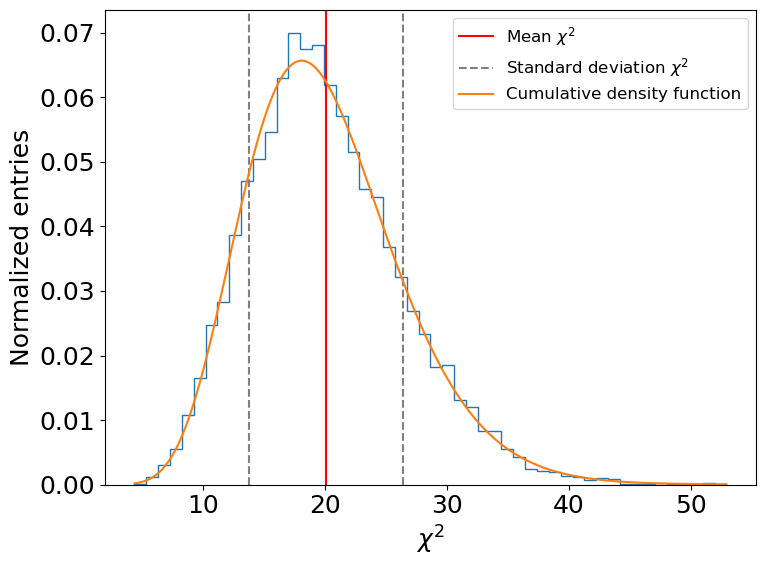

In [ ]:
# Plot parameter distributions
Labels = [r"$m_{\nu}^2$ [eV$^2$]", r"$E_{0}$ [eV]", r"$B$ [cps]", r"N", r"$\chi^2$"]


for param, label in zip(Parameters.T, Labels):
    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
    ax.hist(param, bins=50, histtype="step",density=True)
    mean = np.mean(param)
    std = np.std(param)
    ax.axvline(mean,color='r',label=f"Mean {label}")
    ax.axvline(mean-std,linestyle='--',color='grey',label=f"Standard deviation {label}")
    ax.axvline(mean+std,linestyle='--',color='grey')

        
    plt.locator_params(axis='x', nbins=6)
    ax.set_xlabel(label)
    ax.set_ylabel("Normalized entries")
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"fig/distribution_{label}.png", dpi=300)
    

    
    if label == r"$\chi^2$":
        xlin = np.linspace(np.min(param), np.max(param), 500)
        ylin = stats.chi2.pdf(xlin, df=np.mean(param))
        ax.plot(xlin, ylin, color="tab:orange",label=f"Cumulative density function")
        ax.legend(fontsize=12)
        plt.tight_layout()
        plt.savefig(f"fig/distribution_{label}.png", dpi=300)

### 2.3 Uncertainty and Sensitivity ###

In [ ]:
def profile(mnu2):
    """For given mnu2, minimize the chi2 w.r.t. the other parameters"""
    # Define chi2 as a function of parameters without neutrino mass for fixed Asimov data
    def chi2(params) -> float:
        """Return the chi2 as a function of params"""
        E0, B, N = params
        xdata = Elin
        ydata = rate_asimov
        sigma = np.sqrt(counts_asimov)/(tlin*ttot)
        return chisquared(func=simplified_model, xdata=xdata, ydata=ydata, pmodel=[mnu2, *params], sigma=sigma)
    # Initial guess
    x0 = [18572.,.2,1.]
    # Minimize 
    result = optimize.minimize(chi2, x0=x0, method="Nelder-Mead")
    if result.success:
        return result.fun
    else:
        print(f"Not converged for mnu2={mnu2}")

def root_search(mnu2):
    """Return difference of chi square distribution to 1"""
    return (profile(mnu2)-result_asimov.fun) - 1/2


In [ ]:
result_upper = optimize.root_scalar(root_search, bracket=(0, 5))
if result_upper.converged:
    mnu2_upper = result_upper.root
else:
    print(f"Not converged")
result_lower = optimize.root_scalar(root_search, bracket=(-5, 0))
if result_lower.converged:
    mnu2_lower = result_lower.root
else:
    print(f"Not converged")
    
print(mnu2_lower, mnu2_upper)


/tmp/ipykernel_5473/910648528.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(C * F * p * (E+m_e) * (E_0 - E) * np.sqrt((E_0 - E)**2


-0.03819764220243562 0.03713482867442588


### Likelihood profile

/tmp/ipykernel_5473/910648528.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(C * F * p * (E+m_e) * (E_0 - E) * np.sqrt((E_0 - E)**2
/tmp/ipykernel_5473/306173793.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


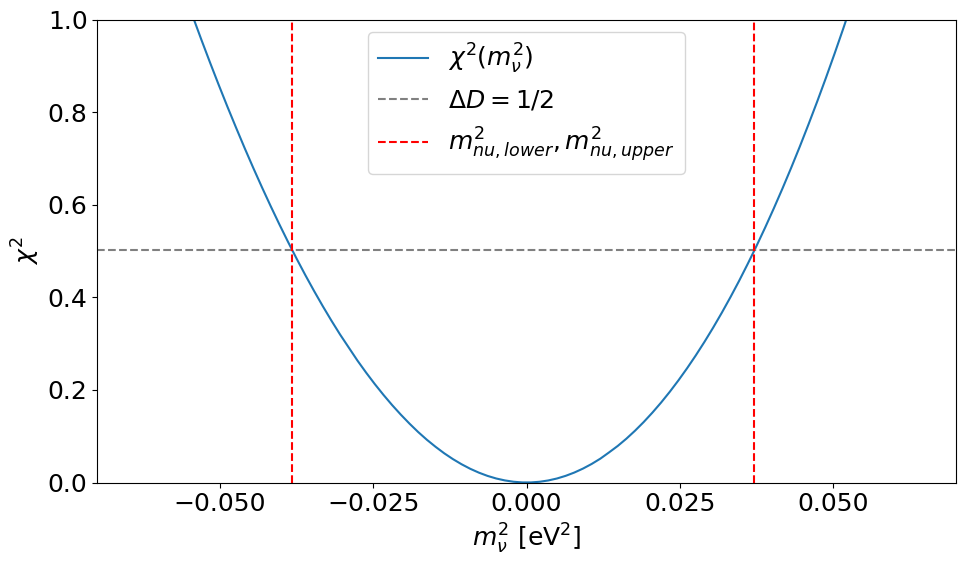

In [ ]:
# Plot a chi2 profile

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6));

# Range of mnu2
x = np.linspace(-0.07,0.07,100) # should go from negative to positive values
y = np.array([profile(_x) for _x in x]) # inser the function name that gives the chi squared value in dependence of mnu2
ax.set_ylim([0,1])
ax.set_xlim([-0.07,0.07])
ax.plot(x, y, label=r"$\chi^2 (m_{\nu}^2)$")

# Plot horizontal lines
ax.axhline(result_asimov.fun+1/2, ls="--", color="gray", label=r"$\Delta D = 1/2$")
ax.axvline(mnu2_lower,linestyle='--',color='r',label=r"$m_{nu,lower}^2, m_{nu,upper}^2$")
ax.axvline(mnu2_upper,linestyle='--',color='red')

plt.locator_params(axis='x', nbins=6);
ax.set_xlabel(r"$m_{\nu}^2$ [eV$^2$]");
ax.set_ylabel(r"$\chi^2$");
ax.legend()

plt.tight_layout()
plt.savefig("fig/LikelihoodProfilenu.png", dpi=300)

### Sensitivity of the KATRIN Experiment.

In [ ]:
print(f"Sensitivity is {np.sqrt(1.645*mnu2_upper):.4f}"+" eV") # insert factor for 90 % C.L.

Sensitivity is 0.2472 eV
